# Unsupervised gear prediction based on speed and rpm

MyWheels is an assitant app for divers. It monitors various parameters of driver's vehicle and journey, collecting various data. Courtesy of MyWheels I was given access to a database collected from real vehicles in their joruneys. There were a little over 1 million observations consisting of vehicle_id, ride_id, timestamp, type of measurement (rpm or speed) and the value of the measurement. **The goal of the project was to produce a model predicting which gear was the vehicle on at any given time.** Since no labels for gears were provided, this is an unsupervised learning problem. 

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Initial exploration

Star by reading in the raw data.

In [25]:
raw_data = pd.read_csv('rides_bootcamp.csv')
raw_data.head()

,vehicle_id,ride_id,timestamp,type,result
0,1,1,1488353758,rpm,1176
1,1,1,1488353759,rpm,1097
2,1,1,1488353760,rpm,833
3,1,1,1488353764,rpm,1014
4,1,1,1488353767,rpm,907


In [26]:
raw_data.describe()

,vehicle_id,ride_id,timestamp,result
count,1.101723e+06,1.101723e+06,1.101723e+06,1.101723e+06
mean,2.463082e+01,2.461462e+02,1.490794e+09,8.597961e+02
std,2.234084e+01,1.353963e+02,1.613134e+06,9.284612e+02
min,1.000000e+00,1.000000e+00,1.488353e+09,0.000000e+00
25%,5.000000e+00,1.480000e+02,1.489498e+09,4.600000e+01
50%,1.700000e+01,2.470000e+02,1.490542e+09,6.940000e+02
75%,4.100000e+01,3.600000e+02,1.492012e+09,1.664000e+03
max,8.200000e+01,5.000000e+02,1.494229e+09,5.800000e+03


There is little over 1.1 million observations in the dataset.

We observe that 82 vehicles made 500 trips.

Currently out data frame has a 'type' column, which says whether given observation is of speed or of rpm. Let's transform the data frame so that rpm and speed have their own columns, merged on timestamp.

In [27]:
rpm = raw_data[raw_data['type'] == 'rpm']
speed = raw_data[raw_data['type'] == 'speed']
rpm = rpm.rename(index = str, columns = {'result':'rpm'})
rpm.drop(['type'], axis = 1, inplace = True)
speed = speed.rename(index = str, columns = {'result':'speed'})
speed.drop(['type'], axis = 1, inplace = True)

In [28]:
rpm.head()

,vehicle_id,ride_id,timestamp,rpm
0,1,1,1488353758,1176
1,1,1,1488353759,1097
2,1,1,1488353760,833
3,1,1,1488353764,1014
4,1,1,1488353767,907


In [29]:
speed.head()

,vehicle_id,ride_id,timestamp,speed
863,1,1,1488353760,6
864,1,1,1488353764,16
865,1,1,1488353768,14
866,1,1,1488353770,9
867,1,1,1488353771,4


In [30]:
data = pd.merge(rpm, speed, how = 'outer', on = ['timestamp','vehicle_id','ride_id'])
data.head()

,vehicle_id,ride_id,timestamp,rpm,speed
0,1,1,1488353758,1176.0,NaN
1,1,1,1488353759,1097.0,NaN
2,1,1,1488353760,833.0,6.0
3,1,1,1488353764,1014.0,16.0
4,1,1,1488353767,907.0,NaN


In [31]:
data.describe()

,vehicle_id,ride_id,timestamp,rpm,speed
count,667126.000000,667126.000000,6.671260e+05,594547.000000,552175.000000
mean,26.693289,260.978996,1.490970e+09,1604.725272,47.732748
std,23.472889,137.996681,1.653692e+06,702.331501,37.715270
min,1.000000,1.000000,1.488353e+09,0.000000,0.000000
25%,5.000000,156.000000,1.489580e+09,930.000000,15.000000
50%,17.000000,275.000000,1.490944e+09,1628.000000,45.000000
75%,43.000000,387.000000,1.492255e+09,2063.000000,72.000000
max,82.000000,500.000000,1.494229e+09,5800.000000,255.000000


We notice that for some timestamps only one type of measurement was taken (either speed or rpm). Let's see how many null values have we got.

In [32]:
data.isnull().sum()

vehicle_id         0
ride_id            0
timestamp          0
rpm            72579
speed         114951
dtype: int64

There is a significant amount of mismatch that occured in our merge. Thera are two ways we can deal with it:
* Interpolate missing values of speed and rpm
* Predict gears disregarding the missing values and later interpolate which gear should they be in

We choose the second approach, as we do not care as much for the speed or rpm at a given timestamp as for the gear. 
Interpolating correct gear will also be easier. Furthemore, incorrect speed/rpm interpolation could lead to introduction of noise into out model. We thus decide to drop null values for now - their gears can be interpolated later.

In [33]:
data.dropna(axis = 0, inplace = True)
data.isnull().sum()

vehicle_id    0
ride_id       0
timestamp     0
rpm           0
speed         0
dtype: int64

In [34]:
data.describe()

,vehicle_id,ride_id,timestamp,rpm,speed
count,479596.000000,479596.000000,4.795960e+05,479596.000000,479596.000000
mean,24.102574,241.854767,1.490732e+09,1625.048339,48.101992
std,22.238750,135.258768,1.596372e+06,703.766683,38.229930
min,1.000000,1.000000,1.488353e+09,0.000000,0.000000
25%,4.000000,139.000000,1.489425e+09,987.000000,15.000000
50%,16.000000,244.000000,1.490463e+09,1646.000000,45.000000
75%,41.000000,354.000000,1.491834e+09,2080.000000,72.000000
max,82.000000,500.000000,1.494229e+09,5800.000000,255.000000


Having joined rpms and speeds on their timestamps, we are left with 479596 observations. From the table below we can also find max, min std and quartiles for both rpm and speed. Before dropping null values there were 667126 observations. This means we have lost nearly 30% of our data. This will not hamper our further approach though, as will be made apparent once we explain our approach. As already noted, for most of these missing datapoints we should be able to interpolate the correct gear from the surrounding data.

## Gear prediction - first approach

Since our dataset contains info on 500 trips of 82 different vehicles and no information is provided on their makes, engines or even number of gears (5, 6?), we first decided to try the following approach.

From literature, we know that rpm vs speed obey a linear relationship, with gradient decreasing with the increase of the gear. We thus expect the graphs of rpm vs speed for each vehicle to look like 5 or 6 lines starting at (0,0) with varying gradients; inversly proportional to the gear. To discover the gear used at a given time, we decided to iterate over every trip of every vehicle and cluster the (speed, rpm) points using KMeans with precomputed cosine distances between them. We decided to use cosine distances as what distinguishes the points is the lines along which they (should) lie, meaning points are simillar if the angles between their position vectors is small, and are dissimilar otherwise. This behaviour is caputer exactly by the cosine metric.

As will be presented below, some outlier detection was also needed. To this end, we decided to employ Isolation Forests.

Below we will present our approach on an example trip 247 of vehicle 41.

We remove the entries where rpm or speed equal 0, since these correspond to turned off engine.

In [35]:
vh = data[(data['vehicle_id'] == 41) & (data['ride_id'] == 247)]
vh = vh[(vh['rpm'] > 0) & (vh['speed'] > 0)] 

In [36]:
vh.head()

,vehicle_id,ride_id,timestamp,rpm,speed
269992,41,247,1490534504,814.0,7.0
269993,41,247,1490534506,1425.0,1.0
269994,41,247,1490534509,1192.0,8.0
269995,41,247,1490534521,792.0,23.0
269996,41,247,1490534522,817.0,17.0


In [37]:
vh.describe()

,vehicle_id,ride_id,timestamp,rpm,speed
count,6161.0,6161.0,6.161000e+03,6161.000000,6161.000000
mean,41.0,247.0,1.490539e+09,1914.030515,74.380620
std,0.0,0.0,2.631638e+03,498.976259,31.381923
min,41.0,247.0,1.490535e+09,768.000000,1.000000
25%,41.0,247.0,1.490536e+09,1668.000000,54.000000
50%,41.0,247.0,1.490540e+09,1968.000000,80.000000
75%,41.0,247.0,1.490541e+09,2171.000000,98.000000
max,41.0,247.0,1.490543e+09,4458.000000,126.000000


In order to gain better appreciation of the data, let's see the graphs of rpm vs time and speed vs time, and speed vs rpm.

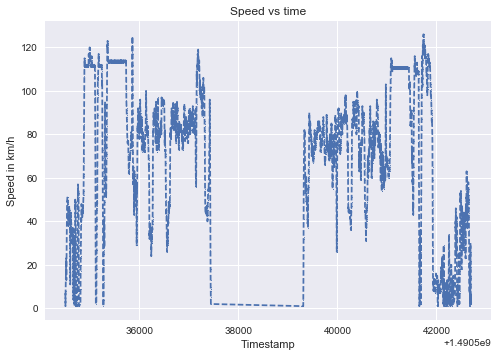

In [47]:
plt.plot(vh['timestamp'],vh['speed'], 'o--', ms=1)
plt.xlabel('Timestamp')
plt.ylabel('Speed in km/h')
plt.title('Speed vs time')
plt.show()

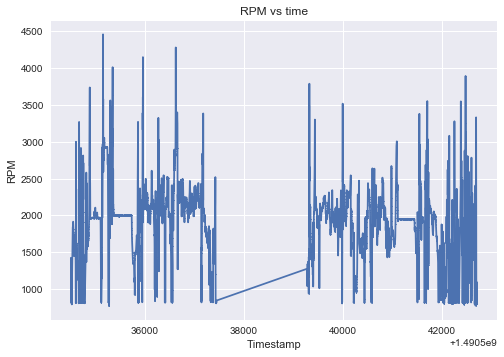

In [48]:
plt.plot(vh['timestamp'],vh['rpm'], 'o-', ms=1)
plt.xlabel('Timestamp')
plt.ylabel('RPM')
plt.title('RPM vs time')
plt.show()

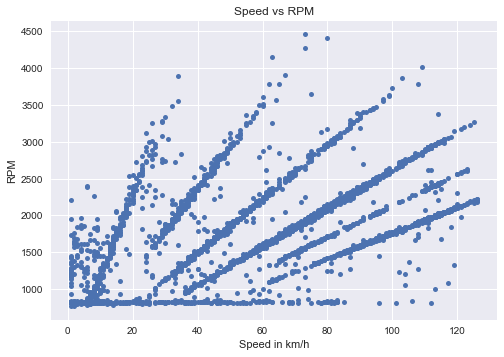

In [49]:
plt.plot(vh['speed'],vh['rpm'], 'o', ms = 5)
plt.ylabel('RPM')
plt.xlabel('Speed in km/h')
plt.title('Speed vs RPM')
plt.show()

We can clearly see that our data mostly follows six lines, each corresponding to a gear. There are obviously some noisy observations as well, as well as some which look like outliers / neautral gear (gear shift) (less than 1000 rpms at more than 100km/h).

Let's have a first go at building our model.

In [50]:
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import KMeans
colours = np.array(sns.color_palette('Set1',100))

In [51]:
distances = pairwise_distances(vh[['rpm','speed']],vh[['rpm','speed']],metric = 'cosine')
model = KMeans(n_clusters=6)
model.fit(distances)
labels = model.labels_

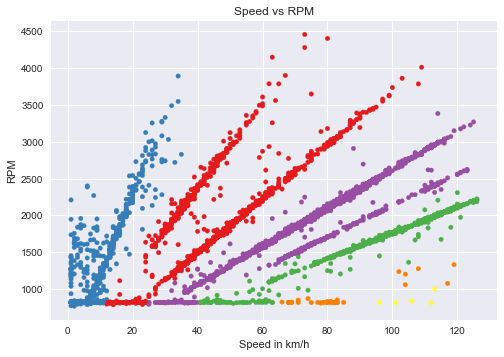

In [52]:
plt.scatter(vh['speed'],vh['rpm'], c = colours[labels], s = 20)
plt.ylabel('RPM')
plt.xlabel('Speed in km/h')
plt.title('Speed vs RPM')
plt.show()

We observe that simply running KMeans on precomputed cosine distances did not yield desired effect. Observations which we earlier thought of as outliers have 'taken up' two gears, forcing two pairs of adjacent gears to coalesce into one.

We thus want to get rid of outliers. To this end, we employ an anomaly detection algorithm know as IsolationForest.
Isolation Forest is a relatively new, tree based anomaly detection algorithm. A gentle introduction to Isolation Forests can be found here: http://blog.easysol.net/using-isolation-forests-anamoly-detection/. For a more comprehensive treatment, see the original paper: https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/icdm08b.pdf 

In [53]:
from sklearn.ensemble import IsolationForest

In [54]:
clf = IsolationForest(max_samples=100, contamination=0.01)
clf.fit(distances)
labels = clf.predict(distances)
vh['outlier'] = labels

In [57]:
vh[['speed','rpm','outlier']].head()

,speed,rpm,outlier
269992,7.0,814.0,1
269993,1.0,1425.0,-1
269994,8.0,1192.0,1
269995,23.0,792.0,1
269996,17.0,817.0,1


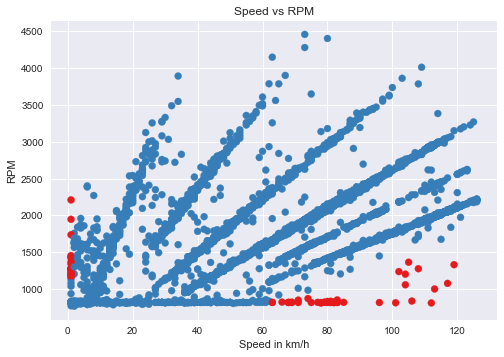

In [58]:
plt.scatter(vh['speed'],vh['rpm'], c = colours[labels])
plt.ylabel('RPM')
plt.xlabel('Speed in km/h')
plt.title('Speed vs RPM')
plt.show()

The graph above shows outliers detected by the IsolationForest (red).

Let's remove the outliers and refit KMeans.

In [59]:
vh_no_outliers = vh[['rpm','speed']][vh['outlier'] == 1]

In [60]:
distances_no_outlier = pairwise_distances(vh_no_outliers, vh_no_outliers, metric='cosine')
model = KMeans(n_clusters=6)
model.fit(distances_no_outlier)
model.labels_

array([1, 1, 3, ..., 1, 1, 1], dtype=int32)

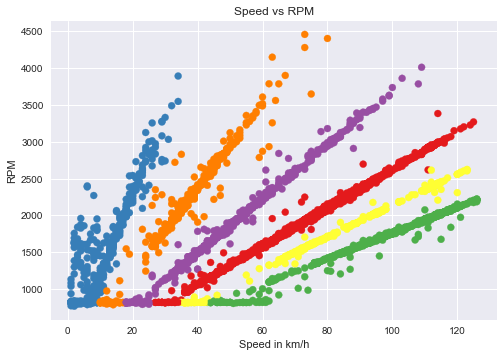

In [61]:
plt.scatter(vh_no_outliers['speed'],vh_no_outliers['rpm'],c = colours[model.labels_])
plt.ylabel('RPM')
plt.xlabel('Speed in km/h')
plt.title('Speed vs RPM')
plt.show()

As we can see, removing outliers had the desired effect and our model correctly assings gears to nearly every point.

As already noted, this approach is followed for all 500 trips. Specifically, we iterate over every vehicle and every trip and each time we first remove outliers with IsolationForest with contamination leve set to 0.01.
Subsequently, we cluster the data into k gears using KMeans for k ranging from 2 to 6 inclusive. We compare silhouette scores for each clustering and choose one with the highest slihouette score. This repostiroy contains a *first_approach.py* script detailing the graph generation process using the approach as described.

Manual check of graphs produced showed that this approach worked well for roughly 75% of the trips. Below we first present a selection of graphs for which the technique wokred well, followed by a selection of examples where our approach was less successful.

In [69]:
from IPython.display import Image
from IPython.display import display

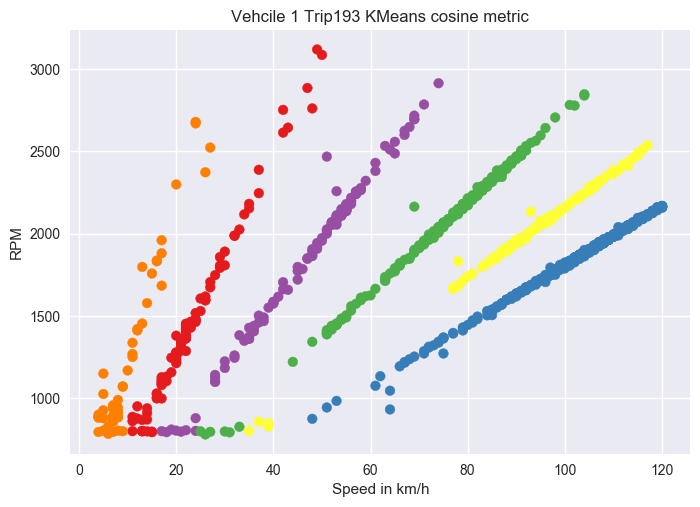

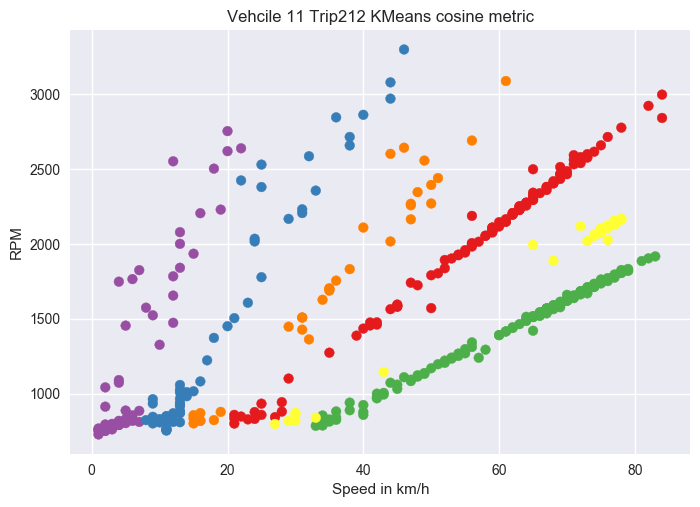

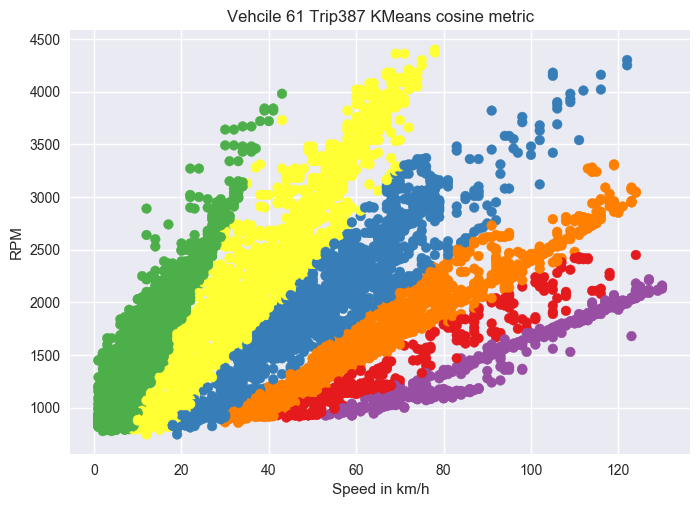

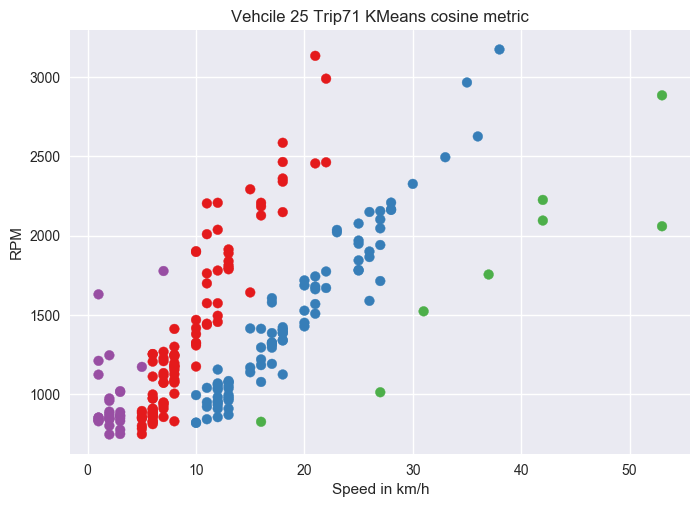

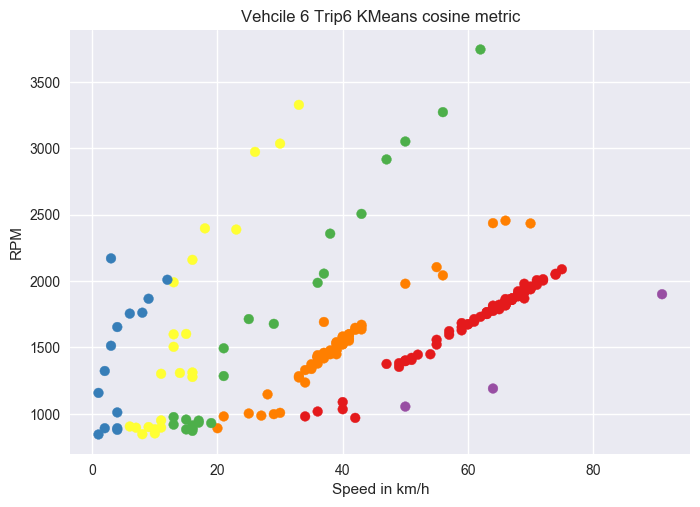

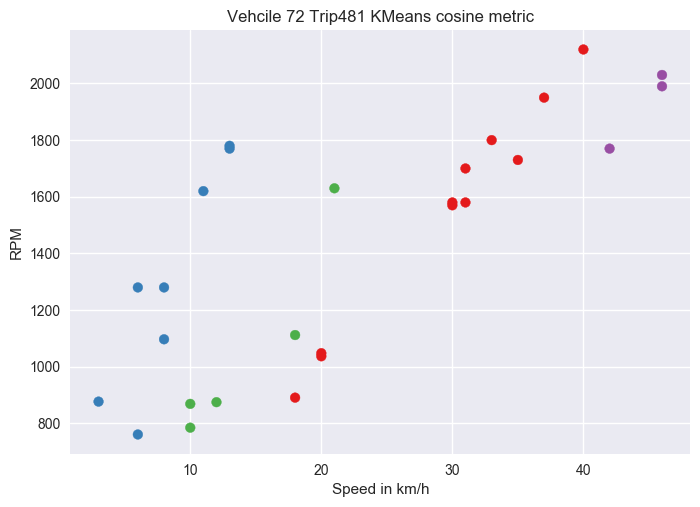

In [80]:
good_trips = ['Vehicle_1_Trip_193 copy.png','Vehicle_11_Trip_212 copy.png', 'Vehicle_61_Trip_387 copy.png', 
          'Vehicle_25_Trip_71 copy.png', 'Vehicle_6_Trip_6 copy.png',
         'Vehicle_72_Trip_481 copy.png']
for image in good_trips:
    display(Image(filename = image))

We see that our algorithm is fairly robust. It works well both with clear, sparated lines, as well as very dense or very sparse graphs.

Let's have a look at trips where our algorithm was less successful.

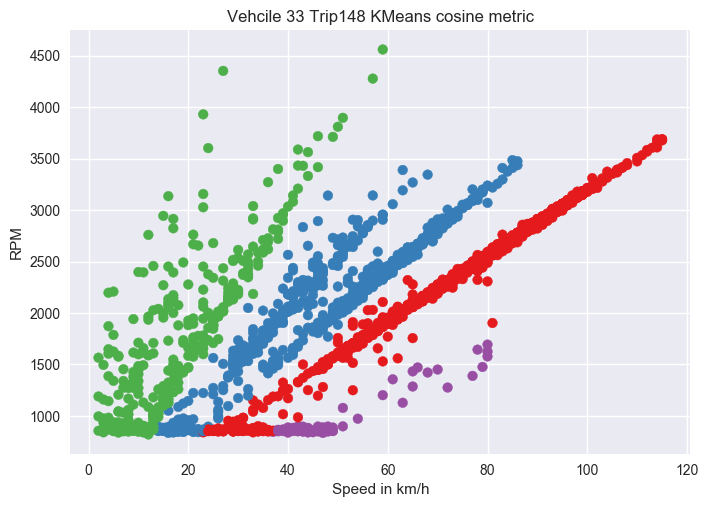

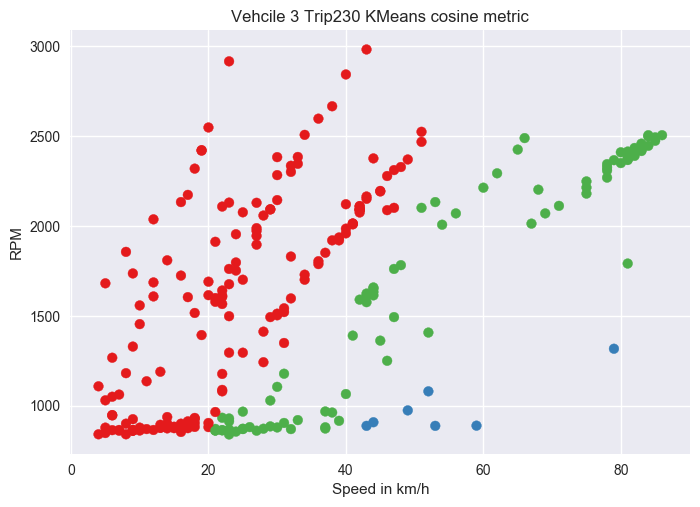

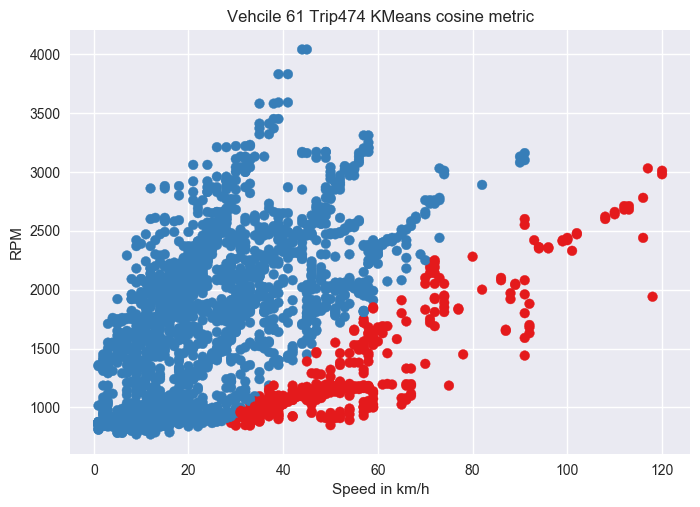

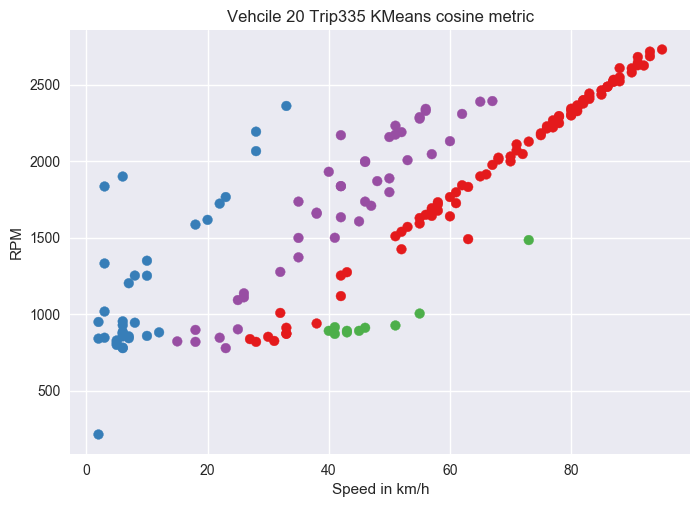

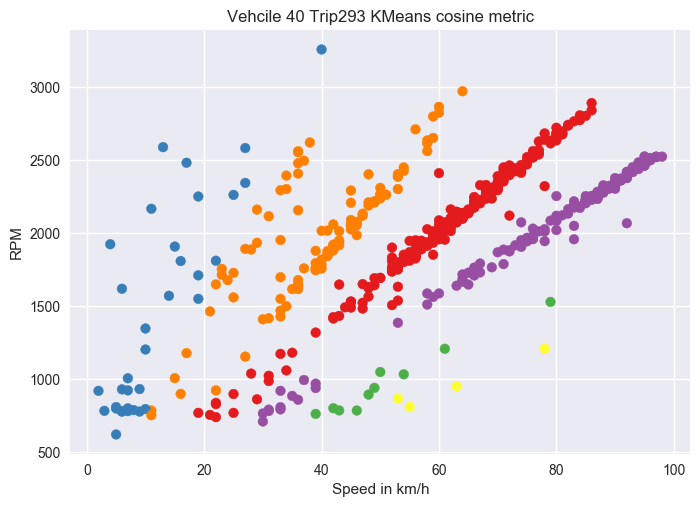

In [82]:
bad_trips = ['Vehicle_33_Trip_148 copy.png','Vehicle_3_Trip_230 copy.png','Vehicle_61_Trip_474 copy.png',
            'Vehicle_20_Trip_335 copy.png','Vehicle_40_Trip_293 copy.png']

for image in bad_trips:
    display(Image(image))

We see that density (or lacktherof) of the data could cause the algorithm to coalesce mutliple gears into one. Similarly, in vehicle 40 trip 293, presence of outliers cause gears 2 and 3 to coalesce into one (in orange on the graph). It may seem that vehicle 20 trip 335 was correclty classified, however on closer inspection it becomes apparent that no driver would be travelling at 70km/h on the 2nd gear. Clearly what is 1st gears in the graph should be split into two gears, 1st and 2nd. 

### Discussion of first approach

* As mentioned ealrier, first approached yielded accuracy of around 75%. However, this metric is heavily biased as it depended on human judgement.
* In different trips same cluster labels correspond to different gears. One way around this would be to find average RPM to speed ratio within each cluster label for each trip and mark the label with highest ratio 1st gear, second highest 2nd gear etc. This however is problematic because in some trips the driver could have used gears 1,2 and 4 only. In such case, gear 4 would be incorrectly labelled as 3.
* Using silhouette score to select k in KMeans clustering did not always produce the desired outcome
* In many cases, misclustering could have been avoided by using different contamination level in IsolationForest and removing more outliers

## Second approach

Based on our theoretical assumption that RPM to speed ratio should be roughly constant for each gear, we devised our second approach. 
From 500 graphs obtain in our earlier investigation, we chose 82 graphs, one for each vehicle. The graphs were chose to be the most 'representative' of each vehicle, ie with clearest and most easily distinugishable theoretical lines and full complement of gears.

For each graph, we computed the average RPM to speed ratio of each cluster label (as obtained in the first approach). Let $m_i$ denote the mean ratio of $i^{th}$ label and suppose $m_i$'s are sorted in decreasing order. Thus highest value of $m_i$ corresponds to first gear, second highest to 2nd gear etc. We then constructed intervals 

$$(m_i - \frac{m_{i} - m_{i+1}}{2}, m_i + \frac{m_{i} - m_{i+1}}{2})$$ 
for each label $i$. Note that each interval is symmetric around $m_i$ with a radius of half of the difference between $m_i$ and the subsequent mean $m_{i+1}$. For the last mean $m_{k}$, we used the same difference $m_{k-1} - m_{k}$ as for the penultimate mean $m_{k-1}$.

Since $m_i$'s where sorted, these intervals are sorted in decreasing order too (with respect to, for example, their left bound) and they correspond to gears 1, 2 up to maximum number of gears, respectively. By convention, we asummed that the first intervals is not bounded from above, as for a lot of trips there were many obvservations with low speeds and very high rpms (corresponding to sudden increase of RPM when a gas pedal is pressed at 1st gear). Thus, for every vehicle, we obtained a function converting an RPM to speed ratio to a gear by lookin at which interval does the ratio fall into. Using these functions, we were quickly able to classify the remaining trips of every vehicly by simply applying the converter function to rpm to speed ratios.

To illustrate our approach, below is a graph showing the regions of space corresponding to each gear of vehicle 41 as obtained from the ratio intervals as described above.

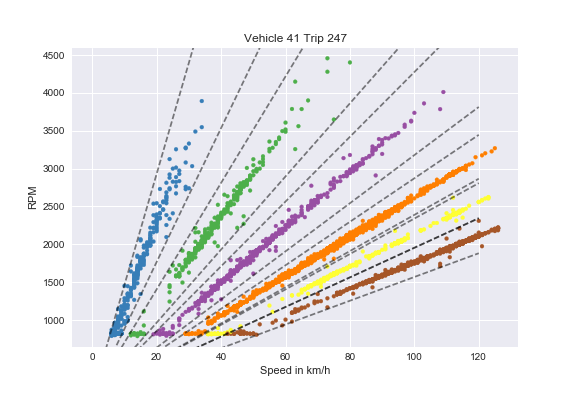

In [85]:
Image("gear_boundaries.png")

Dashed lines represent the boundaries of the intervals of RPM to speed ratios corresponding to each gear.

Below is a function which, given a specific trip, expected number of gears and contamination level of IsolationForest, produces a function to convert RPM to speed ratios to gears.

In [88]:
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.ensemble import IsolationForest

In [87]:
def preprocess(raw_data):
    '''
    This function merges rpm and speed on a timestamp and discards mismatched rows.
    Zero speeds and rpms are discarded, as well as speed over 200.
    Ratio column is added and data frame is returend.
    '''

    rpm = raw_data[raw_data['type'] == 'rpm']
    speed = raw_data[raw_data['type'] == 'speed']

    rpm = rpm.rename(index = str, columns = {'result':'rpm'})
    rpm.drop(['type'], axis = 1, inplace = True)

    speed = speed.rename(index = str, columns = {'result':'speed'})
    speed.drop(['type'], axis = 1, inplace = True)

    data = pd.merge(rpm, speed, how = 'inner', on = ['timestamp','vehicle_id','ride_id'])
    data = data[(data['rpm'] > 0) & ((data['speed'] > 0) & (data['speed'] < 200))]
    data['ratio'] = data['rpm']/data['speed']

    return data

In [86]:
def get_ratio_converter(vehicle_id, ride_id, data, n_gears = 6, contamination = 0.01):
    '''
    Takes a model journey of vehicle_id, ride_id, preprocessed data, number of gears
    of the vehicle and contamination level and outputs a function which converts
    rpm/speed ratios to gears, as predicted by KMeans model with cosine metric.
    WARNING: May take some time to run.
    '''

    vh = data[(data['vehicle_id'] == vehicle_id) & (data['ride_id'] == ride_id)]

    distances = pairwise_distances(vh[['rpm','speed']],
                                    vh[['rpm','speed']],
                                    metric = 'cosine')

    # train a model to remove noisy data, so that clear theoretical lines are left

    clf = IsolationForest(max_samples=100, contamination = contamination)
    clf.fit(distances)
    labels = clf.predict(distances)
    vh['outlier'] = labels
    vh_no_outliers = vh[vh['outlier'] == 1]

    # recompute distances after outliers were removed
    distances_no_outlier = pairwise_distances(vh_no_outliers[['rpm','speed']],
                                              vh_no_outliers[['rpm','speed']],
                                              metric='cosine')

    # cluster data into gears

    model = KMeans(n_clusters=n_gears)
    model.fit(distances_no_outlier)
    vh_no_outliers['labels'] = model.labels_
    
    # find the mean rpm to speed raito for each label and differences betweeen consecutive means
    gear_boundaries = []
    for i in vh_no_outliers['labels'].unique():
        temp = (vh_no_outliers[vh_no_outliers['labels'] == i]['ratio'].mean())
        gear_boundaries.append(temp)

    gear_boundaries = np.array(gear_boundaries)
    gear_boundaries = np.sort(gear_boundaries)[::-1]

    differences = abs(np.diff(gear_boundaries))
    differences = list(differences)
    temp = differences[-1]
    differences.append(temp)

    # create theoretical intervals for each gear
    
    gear_intervals = [(x-i/2,x+i/2) for (x,i) in zip(gear_boundaries,differences)]

    # define a function which converts a RPM to speed ratio into a gear
    # this function is specific to a vehicle of id = vehicle_id
    def ratio_converter(ratio):

        # some vehicles will have fewer than 6 gears, so avoid indexing errors by using try-except clause
        try:
            if ratio > gear_intervals[0][0] and ratio : return 1 #leaving out an upper bound cause usually there are a lot of high rpms near 0 speed
            if ratio > gear_intervals[1][0] and ratio < gear_intervals[1][1]: return 2
            if ratio > gear_intervals[2][0] and ratio < gear_intervals[2][1]: return 3
            if ratio > gear_intervals[3][0] and ratio < gear_intervals[3][1]: return 4
            if ratio > gear_intervals[4][0] and ratio < gear_intervals[4][1]: return 5
            if ratio > gear_intervals[5][0] and ratio < gear_intervals[5][1]: return 6
        except IndexError:
            return None # if not in any interval, it is an outlier
                        # will try to interpolate its value later

    return ratio_converter

A script to find ratio-to-gears convertes for all vehicles, produce 500 graphs and a new database with gears appended can be found in this github repository under the name of *gear_predictions.py*.  All graphs produced with this script can also be found there.

Below are the graphs of trips which were misclassified in our first approach. As we can see, our new technique allowed us to avoid all earlier problems and provided correct gear classification even for difficult graphs.

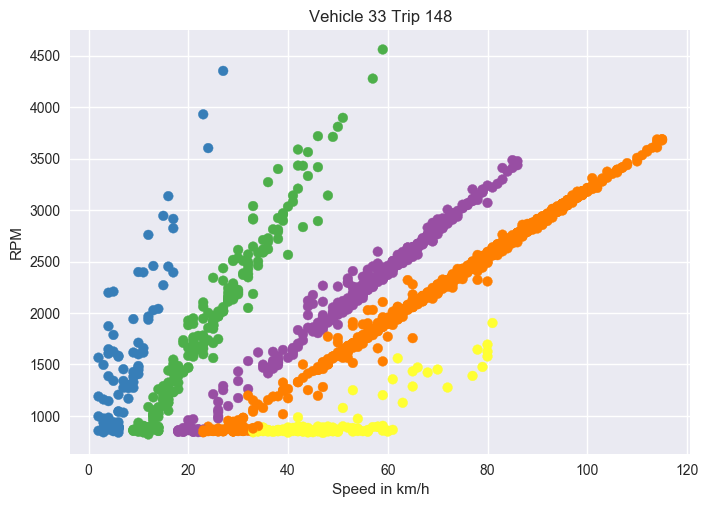

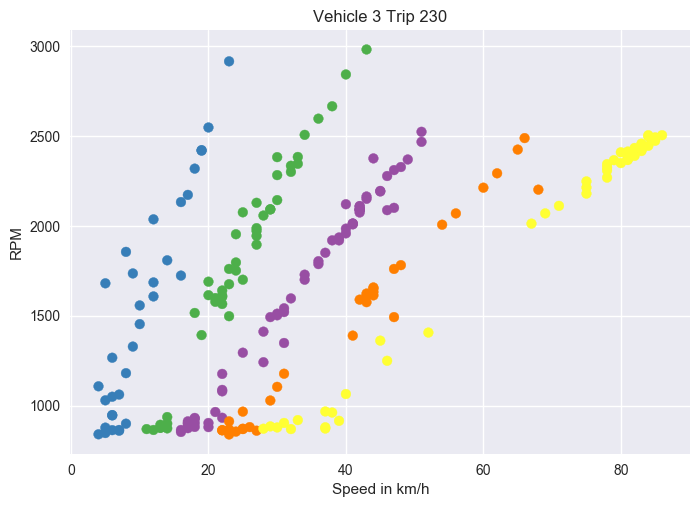

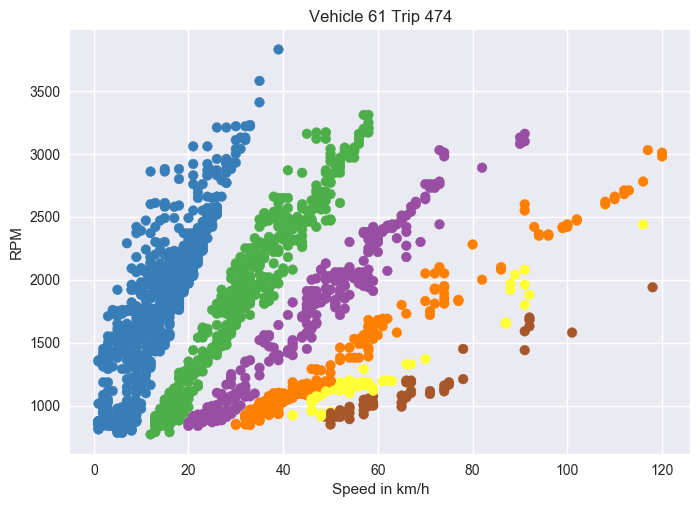

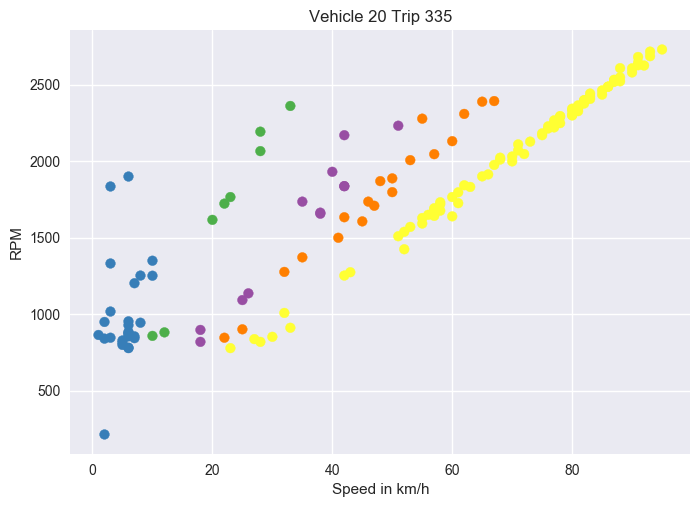

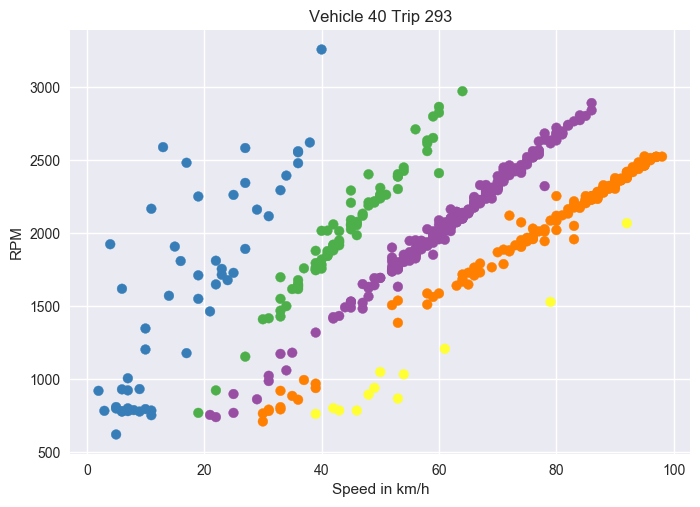

In [90]:
corrected_trips = ['Vehicle_33_Trip_148 copy 2.png','Vehicle_3_Trip_230 copy 2.png','Vehicle_61_Trip_474 copy 2.png',
            'Vehicle_20_Trip_335 copy 2.png','Vehicle_40_Trip_293 copy 2.png']

for image in corrected_trips:
    display(Image(image))

Finally, we appended a 'gear' column to our original database and sorted the database by timestamp, vehicle_id and ride_id. The we used fillna() method with both forward and backword fill and a limit of 5 to interpolate some of the missing gears. As can be seen below, we managed to decrease the number of NA values from initial 187530 to 168005, ie we managed to interpolate the gear even for those timestamps where only one type of measurement was present. We were left with 168005 datapoints with no gear labels because in our original dataset there were long intervals of time where only one type of measurement was taken (rpm or speed, but not both) so it is impossible to correclty infer the gear used at these times. However, it should be noted that this method of filling in NA values leads to some potential mislabellings and its outcome should undergo closer scrutiny. 

In [ ]:
# code snippet from gear_prediction.py used for interpolation

# sort the data by timestamp, vehicle_id and ride_id to allow interpolation
new_data.sort(columns=['timestamp', 'vehicle_id','ride_id'], inplace=True)

# interpolate some of the missing gears on entries where there was a timestamp mismatch
# these were discarded earlier, but we can infer their gear from surrounding gears now

new_data['gear'] = new_data['gear'].fillna(method = 'pad', limit = 5)
new_data['gear'] = new_data['gear'].fillna(method = 'bfill', limit = 5)

# save new dataset to a file
new_data.to_csv('rides_bootcamp_appended.csv')

In [96]:
data_with_gears = pd.read_csv("rides_bootcamp_appended.csv")

In [109]:
print("Total number of points in a databse: {}".format(data_with_gears['gear'].count()))
print("Number of datapoints with no gear label: {}".format(data_with_gears['gear'].isnull().sum()))

Total number of points in a databse: 1072761
Number of datapoints with no gear label: 168005


# Discussion

By manually selecting 82 trips, one for each vehicle, and manually selecting number of gears and contamination level of IsolationForest for each trip, we were able to avoid some of the earlier problems. It was no longer necessary to use silhouette score to pick the best k in KMeans clustering, and we were able to vary the number of outliers removed, improving a classification of a number of trips. We estimate that the new approach allowed us to correclty classify around 90% of trips. Most of the errors are our technique failing for vehicle 4 which had 42 trips in our database (we tried many combinations of contaminaiton levels and different 'model' trip but were unable to obtain a statisfactory classification. This does not mean, however, that all datapoints are assigned the wrong gear. It is only that the classification is not 'perfect' so some points maybe misclassified). The remaining missclassfied trips were mostly for vehicles with very few journeys (1-3) and low quality data (very sparse, no clear theoretical lines).

Pros:
* 90% of trips correctly classified
* improved runtime as compared to earlier approach - only 82 models to fit, as opposed to 500
* essentialy, for each vehicle we obtain an easy function taking RPM to speed ratio as input and outputing gear. If we could collect data on vehciles' makes and engine types, we could reuse the same functions for new clients using the same type of vehciles as already present in our dataset

Cons:
* Need to manually pick 82 'most representative' trips and hardcode their ids, number of gears used and contamination level
* Approach doesn't work with irregular observations (no clear theoretical lines present)
* Hard to verify - only manual expection of graphs

Possible improvements:
* The biggest possible improvement would be to collect labeled data of rpm, speed, timestamp and gear and turn this into a supervised learning problem. This would greatly improve the evaluation part of modelling and allow for investigating more approaches. It would also allow for usage of supervised classification algorithms. Since the MyWheels app was able to collect RPM and speed of a moving vehicle, it should not be unrealistic to collect the gear as well
* Due to presence of many (around 30%) datapoints with only one measurement (speed or rpm) in the original dataset and rather naive approach taken to mitigate that issue, more sophisitcated approaches to fill NA values should be scrutinized, together with better evaluation of the performance of the current interpolation method

### Acknowledgements
The author would like to thank MyWheels for sharing the dataset and Norbert Ryciak for setting out the problem and providing feedback on this notebook.